<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>
    
---

# 5. Hydrogen atom and Metropolis algorithm

## quantum wave function

In quantum physics a **wave function**, $\psi$, is a mathematical description of the state of a quantum system. The wave function is a complex-valued probability amplitude, and the probabilities for the possible results of measurements made on the system can be derived from it.

For now on, let's consider the simple case of a non-relativistic single particle, without spin, in three spatial dimensions. The state of such a particle is completely described by its wave function, $\psi(\vec{r},t)$, where $\vec{r}$ and $t$ show parametrical dependence on both position and time.

For one spinless particle, if the wave function is interpreted as a probability amplitude, the square modulus of the wave function, $|\psi(\vec{r},t)|^2$, is interpreted as the probability density that the particle is at $\vec{r}$ at time $t$. Once we have a probability density, we can use Monte Carlo ...

## Hydrogen atom

The wave functions of the eigenstates of an electron in a Hydrogen atom (this is the only atom for which the Schrödinger equation has been solved exactly) are expressed in terms of spherical harmonics and generalized Laguerre polynomials. It is convenient to use spherical coordinates, and the wave function can be separated into functions of each coordinate:

$$
\psi_{n,l,m}(r,\theta,\phi)=
\sqrt{\left(\frac{2}{na_0}\right)^3 \frac{(n-l-1)!}{2n[(n+l)!]}}
e^{-r/n a_0}\left(\frac{2r}{na_0}\right)^l L_{n-l-1}^{2l+1}\left(\frac{2r}{na_0}\right)
Y_l^m(\theta,\phi)
$$

where 
 - $a_0=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ nm is the Bohr radius
 - $L_{n-l-1}^{2l+1}$ are the generalized Laguerre polynomials of degree $n-l-1$
 - $n=1,2,...$ is the principal quantum number
 - $l=0,1, ..., n-1$ the azimuthal quantum number
 - $m=-l, -l+1, ..., l-1, l$ the magnetic quantum number

For example, the ground state wave function is:
$$
\psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0}
$$
whereas one of the three $2p$ excited state is:
$$
\psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$

<span style="color:blue">The expectation values for the radius turn out to be exactly:
$$
\left\langle r \right\rangle_{\psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\psi_{2,1,0}} = 5 a_0
$$
</span>


## exercise 5.1


Use the Metropolis algorithm to sample $|\psi_{1,0,0}(x,y,z)|^2$ and $|\psi_{2,1,0}(x,y,z)|^2$ **in Cartesian coordinates** using, initially, an uniform transition probability $T(\vec{x}|\vec{y})$ and estimate $\left\langle r \right\rangle_{\psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\psi_{2,1,0}}$. 

As usual, use data blocking and give an estimate of the statistical uncertainties.

<p class="assignement"> Plot your estimations of $\left\langle r \right\rangle_{\psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\psi_{2,1,0}}$</span> and their uncertainties with a large number of <i>throws</i> $M$ (e.g. $M\ge 10^6$) as a function of the number of blocks, $N$</p>

... a few guidelines:

- Use Bohr radius units, $a_0$ for distances
- Choose the step of the **uniform transition probability** $T(\vec{x}|\vec{y})$ in order to obtain **50% of acceptance** in both cases
- Choose a *reasonable* starting point in the 3D space and, **before measuring the radius, equilibrate** your sampling. What do you observe when you start very far from the origin?
- How large should be the number of Monte Carlo Metropolis steps in each block?
- If you use a multivariate normal transition probability $T(\vec{x}|\vec{y})$, i.e. a Gaussian for each coordinate, are your results for $\left\langle r \right\rangle_{\Psi_{1,0,0}}$ and $\left\langle r \right\rangle_{\psi_{2,1,0}}$ equivalent?

### my solution

Since in the Metropolis algorithm the probability densities appear only in the fraction $q = p(x_{\rm new})/p(x_{\rm old})$, one can forget normalization factors.

In Bohr units and with no normalization factors, the probability densities become:

$$
p_{1\rm s}(\vec{r}) = \left|\psi_{1,0,0}(\vec{r})\right|^2=
\frac{1}{\pi a_0^{3}} e^{-2|\vec{r}|/a_0} \sim e^{-2 r'}
$$

and

$$
p_{2\rm p}(\vec{r}) = \left|\psi_{2,1,0}(\vec{r})\right|^2=
\frac{1}{\pi (2a_0)^{5}} z e^{-|\vec{r}|/a_0} \sim z' e^{-r'}
$$

First things first, I'm plotting a 3D scatterplot of $1000$ sampling points for both distributions, to check whether there are any major issue in the shape of the distributions (which have [well known shapes](https://www.falstad.com/qmatom), at least in [theory](https://en.wikipedia.org/wiki/Hydrogen_atom), and can be [visualized dynamically](https://www.youtube.com/watch?v=W2Xb2GFK2yc) as well).

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_05/"
HTML(custom_css())                          # custom notebook appearance (do not suppress output)

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

def plot_3d(ax, file, points, color):
    filename = results_directory + "distribution_" + file + ".dat"    
    data = np.loadtxt(filename)
    x = data[:points,0]
    y = data[:points,1]
    z = data[:points,2]    
    ax.scatter(x, y, z, c=color, marker='.', alpha=.2, label=file + " orbital")

def settings_3d(ax, limit=5):
    ax.view_init(5, 45)
    ax.set_frame_on(False)
    ax.grid(False)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
        
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_zlim(-limit, limit)
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    legend_elements = [Line2D([0], [0], lw=0, marker='o', color='g', label='$|\psi_{2 {\\rm p}}|^2$'), 
                       Line2D([0], [0], lw=0, marker='o', color='r', label='$|\psi_{1 {\\rm s}}|^2$')]
    
    ax.legend(handles=legend_elements, loc="center right");

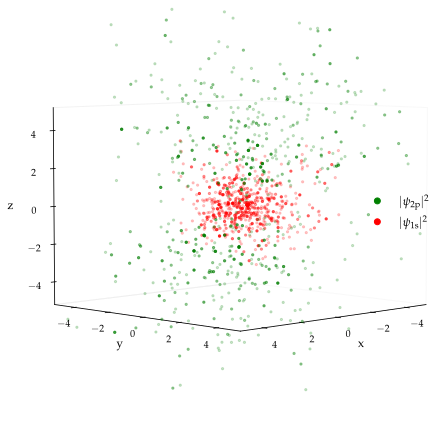

In [3]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection="3d")

points = 1000
plot_3d(ax, "1s", points, "red")
plot_3d(ax, "2p", points, "green")

settings_3d(ax)

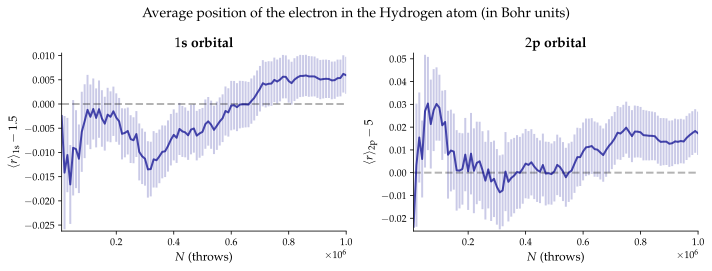

In [4]:
files = [results_directory + "avg_r_1s.dat", results_directory + "avg_r_2p.dat"]
suptitle = "Average position of the electron in the Hydrogen atom (in Bohr units)"
titles = ["$1$s orbital", "$2$p orbital"]
xlabel = "$N$ (throws)"
ylabels = ["$\langle r\\rangle_{1{\\rm s}}-1.5$", "$\langle r\\rangle_{2{\\rm p}}-5$"]
exp_ys = [1.5, 5]

double_estimation(files, suptitle, titles, xlabel, ylabels, exp_ys)